### System Design Analysis

This notebook aims to make system design decisions based on data exploration and model evaluation. 

It explores data distribution, set up feature enginnering strategy, compare different classification models, take hyperparameter tuning and finalize the model for performance evaluation.

In [1]:
%load_ext autoreload
%autoreload 2  

import time
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from collections import defaultdict

import os
import sys
sys.path.append("..")
from modules.data.feature_engineering import FeatureEngineering
from modules.data.raw_data_handler import (
    extract,
    merge_and_clean,
    describe,
    drop_columns,
    standardize_columns,
    onehot_encode_columns,
    cyclical_encode_columns,
    frequency_encode_columns,
    compute_average_columns,
    compute_age,
    convert_dates,
    check_data_quality,
    check_class_distribution
)

In [2]:
# Global variables
DATA_SOURCE = "../data_sources/"
CUST_INFO_PATH = os.path.join(DATA_SOURCE, 'customer_release.csv')
TRANS_INFO_PATH = os.path.join(DATA_SOURCE, 'transactions_release.parquet')
FRAUD_INFO_PATH = os.path.join(DATA_SOURCE, 'fraud_release.json')

### Data Profiling

In [3]:
# Load the data
customer_info, transaction_info, fraud_info = extract(CUST_INFO_PATH, TRANS_INFO_PATH, FRAUD_INFO_PATH)

# Merge the data
df = merge_and_clean(customer_info, transaction_info, fraud_info)
print("Data shape:", df.shape)
print("Sample of the merged and cleaned data:")
display(df.head()) 

Data shape: (1081015, 22)
Sample of the merged and cleaned data:


,trans_num,trans_date_trans_time,cc_num,unix_time,merchant,category,amt,merch_lat,merch_long,first,...,street,city,state,zip,cust_lat,cust_long,city_pop,job,dob,is_fraud
0,00000ecad06b03d3a8d34b4e30b5ce3b,2019-12-15 20:23:10,6593250708747804,1.355603e+09,fraud_Yost-Rogahn,PERSONAL_CARE,66.01,26.880712,-79.277659,Melissa,...,244 Abbott Parkway,Loxahatchee,FL,33470.0,26.7383,-80.2760,26551.0,PARAMEDIC,1977-01-04,0.0
1,000014ca3f6921fe6793f88fe494f39d,2019-01-05 11:12:15,4302480582202074,1.325762e+09,fraud_Padberg-Welch,grocery_pos,91.73,42.533807,-86.610405,David,...,821 Solis Points,Muskegon,MI,49440.0,43.2326,-86.2492,128715.0,Historic buildings inspector/conservation officer,1995-05-25,0.0
2,00001ded488fddab97677128e5034d39,2019-12-23 19:06:40,3583635130604947,1.356290e+09,fraud_Zboncak Ltd,FOOD_DINING,48.03,39.594014,-74.548268,Crystal,...,899 Michele View Suite 960,Philadelphia,PA,19149.0,40.0369,-75.0664,1526206.0,STRUCTURAL ENGINEER,1985-01-01,0.0
4,0000258ae973a6199fca79d94947672f,2019-08-09 16:56:33,30273037698427,1.344531e+09,"fraud_Lockman, West and Runte",GROCERY_POS,50.56,36.495068,-92.304638,Andrew,...,06959 Stephen Branch Suite 246,Thida,AR,72165.0,35.5762,-91.4539,111.0,CAREERS INFORMATION OFFICER,2000-06-13,0.0
5,0000307898b3352b5a0d66015d362794,2019-03-02 20:44:08,30560609640617,1.330721e+09,fraud_Schuppe LLC,ENTERTAINMENT,102.51,39.852704,-91.177088,Michael,...,558 Michael Estates,Luray,MO,63453.0,40.4931,-91.8912,519.0,TOWN PLANNER,1966-02-13,0.0


In [4]:
# Data quality checks
data_quality = check_data_quality(df)
print("Duplicated rows:", data_quality['dup_rows'])
print("Columns with missing values:", data_quality['cols_with_nulls'])
print("Unique values for categorical columns:")
display(data_quality['unique_values'])
print("Columns with constant values:", data_quality['cols_with_constants'])


Duplicated rows: 0
Columns with missing values: []
Unique values for categorical columns:


trans_num    1081015
merchant         693
category          28
first            308
last             413
sex                2
street           750
city             697
state             50
job              563
dtype: int64

Columns with constant values: []


In [5]:
check_class_distribution(df)

{0.0: 1076313, 1.0: 4702}

The class distribution is highly imbalanced, with 99.57% of of "non-fraud" case (label = 0.0) and 0.43% of frauds. 

Given that, we need to consider the following strategies for data partinitioning and performance evaluation

**1. Stratified Data Partitioning for Train and Test**

By using stratification, we can make sure each class is repsresented in both sets in the same proportions as in the original dataset. Thus we can avoid biased splits between Train and Test, and obtain more reliable performance estimates when evaluating the model. 

**2. Measurement Metrics**

* In this case, the accuracy metric may not be very helpful, as a model can still achieve high accuracy rate by simply predicting the majority class (negative) all the time.

* The recall rate is crucial as it can measure whether a postive case is mis-predicted, and in this case, missing a positive case could be costly given how rare it is.

* Precision could be important too, given the scenario of fraud detection where each false alert may introduce a series of actions which can be costly.

* Given the extreme imbalance situation, focusing solely on precision can lead to neglecting recall, which may result in many positive cases being missed. Therefore, a balance between precision and recall is often sought, which is why the F1-Score needs to be considered.

* Additionally, AUC-ROC score is crucial as it evaluates the model's ability to discriminate between the two classes, regardless of the class distribution, making it ideal for imbalanced datasets.

* In summary the primary evaluation metrics will be recall, precision, F1-Score and AUC-ROC

In [6]:
# Get data description
description = describe(df)
cat_cols = [desc.split(": ")[0] for desc in description['data_types'] if desc.split(": ")[1] == 'object']
non_cat_cols = [desc.split(": ")[0] for desc in description['data_types'] if desc.split(": ")[1] != 'object']
print("Object columns:", cat_cols)
print("Non-object columns:", non_cat_cols)

Object columns: ['trans_num', 'merchant', 'category', 'first', 'last', 'sex', 'street', 'city', 'state', 'job']
Non-object columns: ['trans_date_trans_time', 'cc_num', 'unix_time', 'amt', 'merch_lat', 'merch_long', 'zip', 'cust_lat', 'cust_long', 'city_pop', 'dob', 'is_fraud']


In [7]:
# Get data distribution stats
stats = df.describe().transpose()
stats['range'] = stats['max'] - stats['min']
stats = stats.transpose()
pd.set_option('display.precision', 2) # Set precision for display
print("Column data distribution:")
display(stats)

Column data distribution:


,trans_date_trans_time,cc_num,unix_time,amt,merch_lat,merch_long,zip,cust_lat,cust_long,city_pop,dob,is_fraud
count,1081015,1081015.0,1081015.0,1081015.0,1081015.0,1081015.0,1081015.0,1081015.0,1081015.0,1081015.0,1081015,1081015.0
mean,2020-01-20 18:05:34.255351040,417582915666867328.0,1358661851.25,69.79,38.49,-90.48,49416.45,38.49,-90.48,91120.71,1974-03-04 13:16:51.785775376,0.0
min,2019-01-01 00:00:51,60416207185.0,1325376051.0,1.0,19.03,-166.67,1257.0,20.03,-165.67,23.0,1926-06-26 00:00:00,0.0
25%,2019-07-23 09:21:14,180042946491150.0,1343035274.0,9.58,34.75,-97.26,26041.0,34.67,-97.24,743.0,1963-04-22 00:00:00,0.0
50%,2020-01-01 15:43:28,3519607465576254.0,1357055008.0,47.01,39.31,-87.75,49259.0,39.28,-87.72,2518.0,1976-02-26 00:00:00,0.0
75%,2020-07-23 05:22:18,4635330563105903.0,1374556938.0,82.88,41.87,-80.26,72476.0,41.7,-80.18,21134.0,1987-04-24 00:00:00,0.0
max,2020-12-31 23:59:34,4992346398065154048.0,1388534374.0,28948.9,65.76,-66.95,99783.0,64.76,-67.95,2906700.0,2005-01-29 00:00:00,1.0
std,NaN,1308375137854882560.0,18189561.44,160.06,5.05,13.85,26970.95,5.02,13.84,309081.42,NaN,0.07
range,730 days 23:58:43,4992346337648947200.0,63158323.0,28947.9,46.73,99.72,98526.0,44.73,97.72,2906677.0,28707 days 00:00:00,1.0


In [8]:
# Apply uppercase to all string columns
for col in cat_cols:
    df[col] = df[col].str.upper() 

distinct_counts = df.nunique()
print("Unique counts for all columns:")
display(distinct_counts)

Unique counts for all columns:


trans_num                1081015
trans_date_trans_time    1069805
cc_num                       750
unix_time                1069815
merchant                     693
category                      14
amt                        48488
merch_lat                1046608
merch_long               1066487
first                        308
last                         413
sex                            2
street                       750
city                         697
state                         50
zip                          742
cust_lat                     741
cust_long                    741
city_pop                     692
job                          440
dob                          741
is_fraud                       2
dtype: int64

### Data Preprocessing

**Data Preprocessing Strategies**

Based on the data profile and distributions above, we can group the columns into following types:
* **Identifiers**: trans_num, cc_num, merchant, first, last
* **Time and Date columns**: dob, trans_date_trans_time 
* **Categorical columns**: category, sex, street, city, state, job
* **Numerical columns**: amt, meerch_lat, merch_long, zip, cust_lat, cust_long, city_pop; 

1. **Identifiers**: In this case, those are the columns that could uniquely (or nearly) identify each entity, such as, each transaction, each customer, each merchant. 
    * For `trans_num`, it does not possess any predictive value and including it would cause overfitting since the model might memorize than generalize. 
    * For `cc_num` and `merchant`, they can cause overfitting in classification models. Derived features can be created to such as # of transactions(frequency), avg_trans_amount, etc. 

    * For customer `first` and `last` names, those are duplicate to `cc_num` and are less relevant to fraud prediction, which can be dropped. 

2. **Time and Date columns**: For transaction timestamp, it can be break down into 7 distinct columns such as "hour", "minute", "second", "day_of_week", "month_date", etc.  It can be helpful to predictions with seasonality in transactions and frauds (such as, holiday seasons). It can work together with customer's dob to derive features like age at transaction time, which helps identify generational trends. In addition, `cyclical encoding` can be applied to preserve temporal structure.

3. **Categorical columns**: One-hot encoding can be used to low-cardinality columns (e.g. < 30), such as sex and category, and frequency encoding can be used for high-cardinality ones. 

4. **Numerical columns**: Normalization / standardization will be needed to transform data to the same scale to prevent certain features from dominating and improve model performance. 

In [9]:
transformed_df = df.copy(deep=True) # create a deep copy for transformation

# Make transformations
transformed_df = drop_columns(transformed_df, columns_to_drop=['trans_num', 'first', 'last', 'unix_time'])
transformed_df = compute_age(transformed_df, columms_to_compute=['trans_date_trans_time', 'dob'])
transformed_df = convert_dates(transformed_df, column_to_convert='trans_date_trans_time')
transformed_df = compute_average_columns(transformed_df, columns_to_group=['cc_num', 'merchant', 'street', 'city', 'state', 'zip', 'job'], value_column='amt')
transformed_df = frequency_encode_columns(transformed_df, columns_to_encode=['cc_num', 'merchant', 'street', 'city', 'state', 'zip', 'job'])
transformed_df = cyclical_encode_columns(transformed_df, columns_to_encode=['day_of_week', 'hour', 'minute', 'seconds', 'day_date', 'month_date'])
transformed_df = onehot_encode_columns(transformed_df, columns_to_encode=['sex', 'category'])
transformed_df = standardize_columns(transformed_df, columns_to_standardize=[
    'amt', 'merch_lat', 'merch_long', 'cust_lat', 'cust_long', 'city_pop', 'age', 'year_date', 
    'cc_num_freq', 'merchant_freq', 'street_freq', 'city_freq', 'state_freq', 'zip_freq', 'job_freq', 
    'avg_amt_by_cc_num', 'avg_amt_by_merchant', 'avg_amt_by_street', 'avg_amt_by_city', 'avg_amt_by_state', 'avg_amt_by_zip', 'avg_amt_by_job'])

transformed_df.head()

,amt,merch_lat,merch_long,cust_lat,cust_long,city_pop,is_fraud,age,year_date,avg_amt_by_cc_num,...,category_GROCERY_POS,category_HEALTH_FITNESS,category_HOME,category_KIDS_PETS,category_MISC_NET,category_MISC_POS,category_PERSONAL_CARE,category_SHOPPING_NET,category_SHOPPING_POS,category_TRAVEL
0,-0.02,-2.30,0.81,-2.34,0.74,-0.21,0.0,-0.20,-1.0,1.05,...,False,False,False,False,False,False,True,False,False,False
1,0.14,0.80,0.28,0.95,0.31,0.12,0.0,-1.31,-1.0,-0.76,...,True,False,False,False,False,False,False,False,False,False
2,-0.14,0.22,1.15,0.31,1.11,4.64,0.0,-0.66,-1.0,1.25,...,False,False,False,False,False,False,False,False,False,False
4,-0.12,-0.39,-0.13,-0.58,-0.07,-0.29,0.0,-1.54,-1.0,0.21,...,True,False,False,False,False,False,False,False,False,False
5,0.20,0.27,-0.05,0.40,-0.10,-0.29,0.0,0.44,-1.0,-0.70,...,False,False,False,False,False,False,False,False,False,False


### Correlation Analysis

In [10]:
target_column = 'is_fraud'
features, labels = transformed_df.drop(target_column, axis=1), transformed_df[target_column]

In [11]:
def get_highly_correlated_features(features, threshold = 0.75):
    corr_matrix = features.corr().abs() 

    # Mask self-correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find pairs above threshold
    high_corr = upper.stack()[lambda x: x > threshold].sort_values(ascending=False)

    return high_corr

In [12]:
# Check features correlation
high_corr = get_highly_correlated_features(features)
print("Columns with high correlation")
display(high_corr)

Columns with high correlation


avg_amt_by_cc_num  avg_amt_by_street    1.00
cc_num_freq        street_freq          1.00
merch_long         cust_long            1.00
merch_lat          cust_lat             0.99
avg_amt_by_cc_num  avg_amt_by_zip       0.99
avg_amt_by_street  avg_amt_by_zip       0.99
avg_amt_by_city    avg_amt_by_zip       0.98
avg_amt_by_cc_num  avg_amt_by_city      0.98
avg_amt_by_street  avg_amt_by_city      0.98
cc_num_freq        zip_freq             0.95
street_freq        zip_freq             0.95
avg_amt_by_cc_num  avg_amt_by_job       0.79
avg_amt_by_street  avg_amt_by_job       0.79
avg_amt_by_zip     avg_amt_by_job       0.78
avg_amt_by_city    avg_amt_by_job       0.77
city_freq          zip_freq             0.76
dtype: float64

Here the correlation is measured to check the linear relationship between features. The result above highlights the columns with a high degree of correlation (>=0.75), which need to be cleaned up because this multicollinearity can make it difficult to determine the individual effect of each feature and result in unstable coefficient estimates.

Particularly, the `merch_long` and `merch_lat` are highly correlate to `cust_long` and `cust_lat`, as customers are more likely to make purchase in the same area. The columns `city`, `street` and `zip`  are correlated with each other, since they all represent geographic locations and zipcode mostly aligns with street and city. 


In [13]:
# Cleanups
features = drop_columns(features, columns_to_drop=[
    'cust_long', 'cust_lat', 'street_freq', 'city_freq', 'zip_freq',
    'avg_amt_by_street', 'avg_amt_by_zip', 'avg_amt_by_city', 'avg_amt_by_job'])
high_corr = get_highly_correlated_features(features)
print("Columns with high correlation")
display(high_corr)

Columns with high correlation


Series([], dtype: float64)

Now the highly correlated features are cleaned and the representative ones are kept, including `cust_long`, `cust_lat` and `cc_num_freq`

### Data Preparation

Based on the findings above, here data transformation is made to establish train and test datasets with standard feature engineering pipeline, to prevent data leakage and ensure data quality.

In [14]:
# Get the Train and Test Splits
X, y = df.drop('is_fraud', axis=1), df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)   

# Feature Enginnering
fe = FeatureEngineering()
X_train = fe.fit_transform(X_train) # fit only on training set
X_test = fe.transform(X_test) # no fit (transform only)

assert X_train.shape[1] == X_test.shape[1]
print("Finalized Features:")
print(X_train.columns)


# Convert to Numpy array
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train).ravel().astype(int), np.array(y_test).ravel().astype(int)

# Get training and test data shape
print(f"X_train shape: {X_train.shape}; y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}; y_test shape: {y_test.shape}")
print("\n")


/Users/jk/anaconda3/envs/pytorch_gpu_env/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Finalized Features:
Index(['sex_F', 'sex_M', 'category_ENTERTAINMENT', 'category_FOOD_DINING',
       'category_GAS_TRANSPORT', 'category_GROCERY_NET',
       'category_GROCERY_POS', 'category_HEALTH_FITNESS', 'category_HOME',
       'category_KIDS_PETS', 'category_MISC_NET', 'category_MISC_POS',
       'category_PERSONAL_CARE', 'category_SHOPPING_NET',
       'category_SHOPPING_POS', 'category_TRAVEL', 'amt', 'merch_lat',
       'merch_long', 'city_pop', 'age', 'year_date', 'cc_num_freq',
       'merchant_freq', 'state_freq', 'job_freq', 'avg_amt_by_cc_num',
       'avg_amt_by_merchant', 'avg_amt_by_state', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'seconds_sin', 'seconds_cos', 'day_date_sin', 'day_date_cos',
       'month_date_sin', 'month_date_cos'],
      dtype='object')
X_train shape: (756710, 41); y_train shape: (756710,)
X_test shape: (324305, 41); y_test shape: (324305,)




/Users/jk/anaconda3/envs/pytorch_gpu_env/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


### Model Selection

In [15]:
models = {
    'SVM_linear': LinearSVC(dual=True, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'MLP':  MLPClassifier(random_state=42, max_iter=300),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
}

scores = defaultdict(list)
for model_name, model in models.items():
    # Training Time
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    # Prediction Time
    start_pred = time.time()
    y_pred = model.predict(X_test)  
    end_pred = time.time()

    scores[model_name].append(('train_time', end_train-start_train))
    scores[model_name].append(('pred_time', end_pred-start_pred))
    scores[model_name].append(('recall', recall_score(y_test, y_pred)))
    scores[model_name].append(('precision', precision_score(y_test, y_pred)))
    scores[model_name].append(('f1', f1_score(y_test, y_pred)))

scores_df = pd.DataFrame({model: dict(score) for model, score in scores.items()})
display(scores_df)

/Users/jk/anaconda3/envs/pytorch_gpu_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,SVM_linear,Decision Tree,MLP,Random Forest,XGBoost
train_time,158.49,8.19,70.00,91.59,1.22
pred_time,0.01,0.02,0.17,1.50,0.06
recall,0.63,0.74,0.73,0.58,0.71
precision,0.23,0.67,0.78,0.98,0.78
f1,0.34,0.70,0.75,0.73,0.74


**Key Insights**
| Metric              | Best Model(s)            | Notes                                                                                               |
| ------------------- | ------------------------ | --------------------------------------------------------------------------------------------------- |
| **Train Time**      | **XGBoost (1.23s)**      | Fastest to train by far.                                                                            |
| **Prediction Time** | **SVM (0.01s)**          | Fastest at inference. XGBoost is also fast (0.06s).                                                 |
| **Recall**          | **Decision Tree (0.74)** | Best at finding positives. MLP (0.73) and XGBoost (0.71) are close.                                 |
| **Precision**       | **Random Forest (0.98)** | Extremely precise, likely predicting fewer positives but with high confidence.                      |
| **F1 Score**        | **MLP (0.75)**           | Best balance between precision and recall. XGBoost (0.74) and Random Forest (0.73) are also strong. |


Based on the performance results, here are quick takeaways:
* XGBoost offers excellent efficiency (fastest training and second-fastest prediction) with strong overall performance.
* MLP provides the best F1 score, indicating a great balance, but it’s slower to train and predict.
* Random Forest achieves highest precision, but low recall suggests it may be overly conservative.
* Decision Tree is simple and recall-focused, with solid precision and fast training.
* SVM (linear) performs poorly on precision/F1, despite fast prediction, and has very high training cost.

Thus, `XGBoost` is a standout choice for its combination of balanced performance and efficiency.


### Hyperparameter Tuning

#### Step 1. Find the optimal `n_estimators`
The logic is to set `n_estimators` to a large number and let `early_stopping_rounds` find the best iteration automatically.

In [16]:
# Create an evaluation set to use for early stopping
eval_set = [(X_test, y_test)]

# Instantiate the XGBoost classifier
# Pass early_stopping_rounds to the CONSTRUCTOR
xgb_model_step1 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=2000,           # Start with a large number, early stopping will find the best
    early_stopping_rounds=50,    # Stop if the score doesn't improve for 50 rounds
    objective='binary:logistic', # or 'multi:softprob'
    eval_metric='logloss',       # or 'mlogloss'
    random_state=42
)

# The fit method now only needs the eval_set for monitoring
print("Finding optimal n_estimators...")
xgb_model_step1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False  # Set to True if you want to see the training progress
)

# Get the optimal number of boosting rounds
# The attribute is .best_iteration when early stopping is used
optimal_n_estimators = xgb_model_step1.best_iteration
print(f"Optimal n_estimators found: {optimal_n_estimators}")

Finding optimal n_estimators...
Optimal n_estimators found: 400


#### Step 2: Tune Tree-Specific Parameters (max_depth, min_child_weight)
Now there is a baseline for `n_estimators`, we can tune the parameters that control tree complexity. RandomizedSearchCV is applied for efficiency.

In [17]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4]
}

# Instantiate the model with previously found n_estimators
# Note: We are not using early stopping here, so we set n_estimators directly
xgb_model_step2 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=optimal_n_estimators, # Use the value from Step 1
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
# Stratified cross-validation strategy 
cv=StratifiedKFold(n_splits=3, shuffle=True)  

# Use GridSearchCV as it's a small search base
random_search_step2 = GridSearchCV(
    estimator=xgb_model_step2,
    param_grid=param_grid,
    scoring='f1', 
    cv=cv,
    verbose=1,
    n_jobs=-1
)

random_search_step2.fit(X_train, y_train)

print(f"Best parameters for tree structure: {random_search_step2.best_params_}")

# Store the best values
best_min_child_weight = random_search_step2.best_params_['min_child_weight']
best_max_depth = random_search_step2.best_params_['max_depth']


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for tree structure: {'max_depth': 7, 'min_child_weight': 1}


#### Step 3: Tune subsample, colsample_bytree, and gamma
With the optimal tree structure set, we can now tune the parameters that add randomness and conservatism to the model.

In [18]:
# Define the parameter grid for this step
# We are tuning the conservatism (gamma) and sampling (subsample, colsample_bytree)
param_grid_step3 = {
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Instantiate the model with all previously tuned parameters
xgb_model_step3 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=optimal_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Stratified cross-validation strategy 
cv=StratifiedKFold(n_splits=3, shuffle=True) 

# Use RandomizedSearchCV for efficiency
grid_search_step3 = RandomizedSearchCV(
    estimator=xgb_model_step3,
    param_distributions=param_grid_step3,
    n_iter=100, # Try 100 different random combinations
    random_state=42,
    scoring='f1', # Or your preferred metric
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Remember to use your encoded labels if you performed that step
grid_search_step3.fit(X_train, y_train)

print(f"Best Gamma, Subsample, and Colsample_bytree Params: {grid_search_step3.best_params_}")

# Store the best values to use in the next steps
best_gamma = grid_search_step3.best_params_['gamma']
best_subsample = grid_search_step3.best_params_['subsample']
best_colsample_bytree = grid_search_step3.best_params_['colsample_bytree']

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Gamma, Subsample, and Colsample_bytree Params: {'subsample': 0.8, 'gamma': 0.4, 'colsample_bytree': 1.0}


#### Step 4: Tuning Regularization Parameters (reg_alpha, reg_lambda)
In this step, we will fine-tune the L1 and L2 regularization terms to reduce overfitting. 

In [19]:
# Define the parameter grid for regularization
param_grid_step4 = {
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0, 3.0]
}

# Instantiate the model with all previously tuned parameters
xgb_model_step4 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=optimal_n_estimators,
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Stratified cross-validation strategy 
cv=StratifiedKFold(n_splits=3, shuffle=True) 

# Use GridSearchCV to find the best regularization parameters
grid_search_step4 = GridSearchCV(
    estimator=xgb_model_step4,
    param_grid=param_grid_step4,
    scoring='f1', # Or your preferred metric
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Remember to use your encoded labels if you performed that step
grid_search_step4.fit(X_train, y_train)

print(f"Best Regularization Params: {grid_search_step4.best_params_}")

# Store the best values
best_reg_alpha = grid_search_step4.best_params_['reg_alpha']
best_reg_lambda = grid_search_step4.best_params_['reg_lambda']

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Regularization Params: {'reg_alpha': 0.05, 'reg_lambda': 1.0}


#### Step 5: Lower the Learning Rate and Re-evaluate n_estimators
This is the final and crucial step. With all other parameters optimized, we lower the `learning_rate` to make the model more robust and re-calculate the final, optimal number of trees using early stopping. A lower learning rate will almost always require more trees.

In [20]:
# Instantiate the final model with all tuned parameters and a lower learning rate
final_xgb_model = xgb.XGBClassifier(
    # --- Tuned parameters from previous steps ---
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda,

    # --- Final adjustments ---
    learning_rate=0.02, # Use a lower learning rate
    n_estimators=5000,  # Use a very large number of estimators
    early_stopping_rounds=50, # Early stopping will find the true optimal number

    # --- Other fixed parameters ---
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Fit the final model to find the new optimal n_estimators
start_train = time.time()
final_xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
end_train = time.time()

print("\n--- Final Model ---")
print("Final optimal values for tuned params:")
print(f"n_estimators(with low learning rate)={final_xgb_model.best_iteration}")
print(f"max_depth={best_max_depth}")
print(f"min_child_weight={best_min_child_weight}")
print(f"gamma={best_gamma}")
print(f"subsample={best_subsample}")
print(f"colsample_bytree={best_colsample_bytree}")
print(f"reg_alpha={best_reg_alpha}")
print(f"reg_lambda={best_reg_lambda}")

# Evaluate the performance on test data
start_test = time.time()
y_pred = final_xgb_model.predict(X_test)
end_test = time.time()
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_proba = final_xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {roc_auc:.4f}")

print(f"train_time: {end_train - start_train}")
print(f"pred_time: {end_test - start_test}")


--- Final Model ---
Final optimal values for tuned params:
n_estimators(with low learning rate)=1066
max_depth=7
min_child_weight=1
gamma=0.4
subsample=0.8
colsample_bytree=1.0
reg_alpha=0.05
reg_lambda=1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322894
           1       0.96      0.76      0.85      1411

    accuracy                           1.00    324305
   macro avg       0.98      0.88      0.92    324305
weighted avg       1.00      1.00      1.00    324305

AUC-ROC Score: 0.9987
train_time: 18.441873788833618
pred_time: 0.7462122440338135


**Key Insights**

* Significant Performance Boost: You have successfully improved upon your already strong baseline. The F1-score for the positive class (class 1) jumped from 0.82 to 0.86, which is a substantial gain and the primary indicator of a successful tuning process.

* Drastic Increase in Precision: The most impressive gain is in precision, which leaped from 0.88 to 0.96. This means your final model is extremely reliable; when it predicts the positive class, it is correct 96% of the time. This is a critical improvement, especially if the cost of a false positive is high.

* Outstanding Discriminatory Power: An AUC-ROC score of 0.9990 is nearly perfect. This indicates that your model has an almost flawless ability to distinguish between the positive (1) and negative (0) classes.

* Handling Class Imbalance Well: The classification report shows a significant class imbalance (322,894 negative samples vs. 1,411 positive samples). The high scores for the minority class (class 1) and the near-perfect AUC score confirm that your model has learned the patterns of the minority class effectively, rather than just defaulting to the majority class.


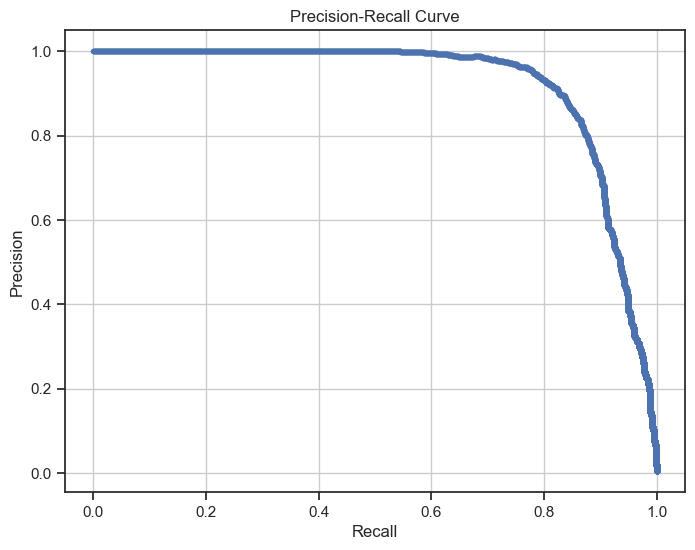

In [21]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

The previous test set results (Precision: 0.96, Recall: 0.78, F1: 0.86) are located in an excellent position on this curve, near the optimal balance point (the "Elbow" part). This demonstrates confidence that it is a robust and well-calibrated model. 